In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()  # set the style

In [3]:
# read data
df = pd.read_csv('./Data-Science-with-Python/data/groupon.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   deal_id          710 non-null    object
 1   start_date       710 non-null    object
 2   min_req          710 non-null    int64 
 3   treatment        710 non-null    int64 
 4   prom_length      710 non-null    int64 
 5   price            710 non-null    int64 
 6   discount_pct     710 non-null    int64 
 7   coupon_duration  710 non-null    int64 
 8   featured         710 non-null    int64 
 9   limited_supply   710 non-null    int64 
 10  fb_likes         710 non-null    int64 
 11  quantity_sold    710 non-null    int64 
 12  revenue          710 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 72.2+ KB


In [5]:
df

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,whitewater-challengers-9,5/2/2012,1,0,5,45,54,164,0,1,110,170,7650
706,world-domination-events,6/23/2012,1,0,8,149,67,52,0,1,116,150,22350
707,xtreme-xperience-chicago,7/27/2012,1,0,4,159,60,29,0,1,104,130,20670
708,your-neighborhood-theatre,4/12/2012,1,0,4,19,51,187,0,1,93,1000,19000


In [11]:
df.iloc[:, 2:].groupby(['treatment']).mean()

,min_req,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
treatment,,,,,,,,,,
0,1.00000,3.809717,37.870445,52.973684,95.941296,0.105263,0.852227,77.941296,333.002024,9720.987854
1,26.50463,3.379630,29.421296,53.263889,131.842593,0.143519,0.777778,113.203704,509.351852,12750.694444


In [12]:
# separate control and treatment for t-test
df_control = df[df.treatment==0]
df_treatment = df[df.treatment==1]

In [13]:
# student's t-test for revenue (dependent variable)
from scipy.stats import ttest_ind

print(df_control.revenue.mean(), df_treatment.revenue.mean())

# compare samples
_, p = ttest_ind(df_control.revenue, df_treatment.revenue)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

9720.987854251012 12750.694444444445
p=0.040
different distributions/different group mean (reject H0)


In [14]:
# student's t-test for facebook likes (dependent variable)
from scipy.stats import ttest_ind

print(df_control.fb_likes.mean(), df_treatment.fb_likes.mean())

# compare samples
_, p = ttest_ind(df_control.fb_likes, df_treatment.fb_likes)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')


77.9412955465587 113.20370370370371
p=0.004
different distributions/different group mean (reject H0)


In [15]:
# choose features for propensity score calculation
X = df[['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'limited_supply']]
y = df['treatment']

X.head()

,prom_length,price,discount_pct,coupon_duration,featured,limited_supply
0,4,99,51,185,1,1
1,2,95,41,9,0,1
2,3,25,50,38,0,1
3,3,50,50,369,0,1
4,4,25,52,185,0,1


In [16]:
# use logistic regression to calculate the propensity scores
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)


LogisticRegression()

In [17]:
# get the coefficients 
lr.coef_.ravel()

array([-0.32837139, -0.0085971 , -0.00794036,  0.00352025,  0.30799496,
       -0.3664981 ])

In [18]:
# get the feature names
X.columns.to_numpy()

array(['prom_length', 'price', 'discount_pct', 'coupon_duration',
       'featured', 'limited_supply'], dtype=object)

In [19]:
# combine features and coefficients into a dataframe
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel(),
})
coeffs

,column,coeff
0,prom_length,-0.328371
1,price,-0.008597
2,discount_pct,-0.007940
3,coupon_duration,0.003520
4,featured,0.307995
5,limited_supply,-0.366498


In [20]:
# prediction
pred_binary = lr.predict(X)  # binary 0 control, 1, treatment
pred_prob = lr.predict_proba(X)  # probabilities for classes

print('the binary prediction is:', pred_binary[0])
print('the corresponding probabilities are:', pred_prob[0])

the binary prediction is: 0
the corresponding probabilities are: [0.7408075 0.2591925]


In [21]:
# the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
df['ps'] = pred_prob[:, 1]

# calculate the logit of the propensity score for matching if needed
# I just use the propensity score to match in this tutorial
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

df['ps_logit'] = df.ps.apply(lambda x: logit(x))

df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps,ps_logit
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460,0.259192,-1.050170
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050,0.230198,-1.207194
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500,0.288405,-0.903144
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500,0.511781,0.047131
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500,0.325212,-0.729919


/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='ps', ylabel='Count'>

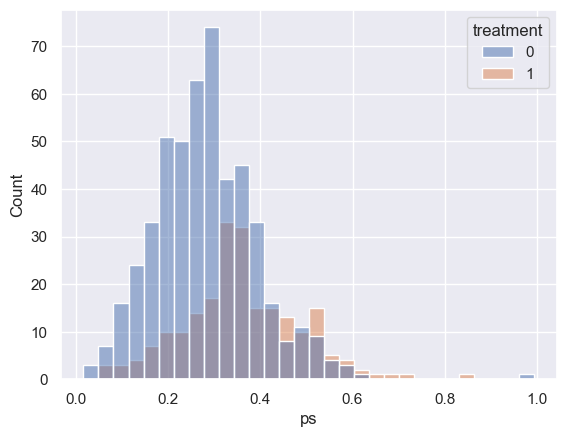

In [22]:
# check the overlap of ps for control and treatment using histogram
# if not much overlap, the matching won't work
sns.histplot(data=df, x='ps', hue='treatment')  # multiple="dodge" for 

/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='ps1', ylabel='Count'>

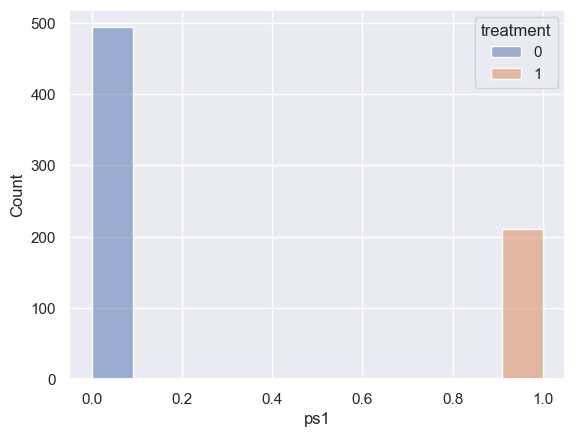

In [24]:
#  adding 'min_req' here makes matching not working - because treatment is derived from min_req
# there is no overlap and thus matching will not work
X1 = df[['min_req', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X1, y)

pred_prob1 = lr1.predict_proba(X1)  # probabilities for classes
df['ps1'] = pred_prob1[:, 1]

sns.histplot(data=df, x='ps1', hue='treatment')

<Axes: xlabel='start_date', ylabel='revenue'>

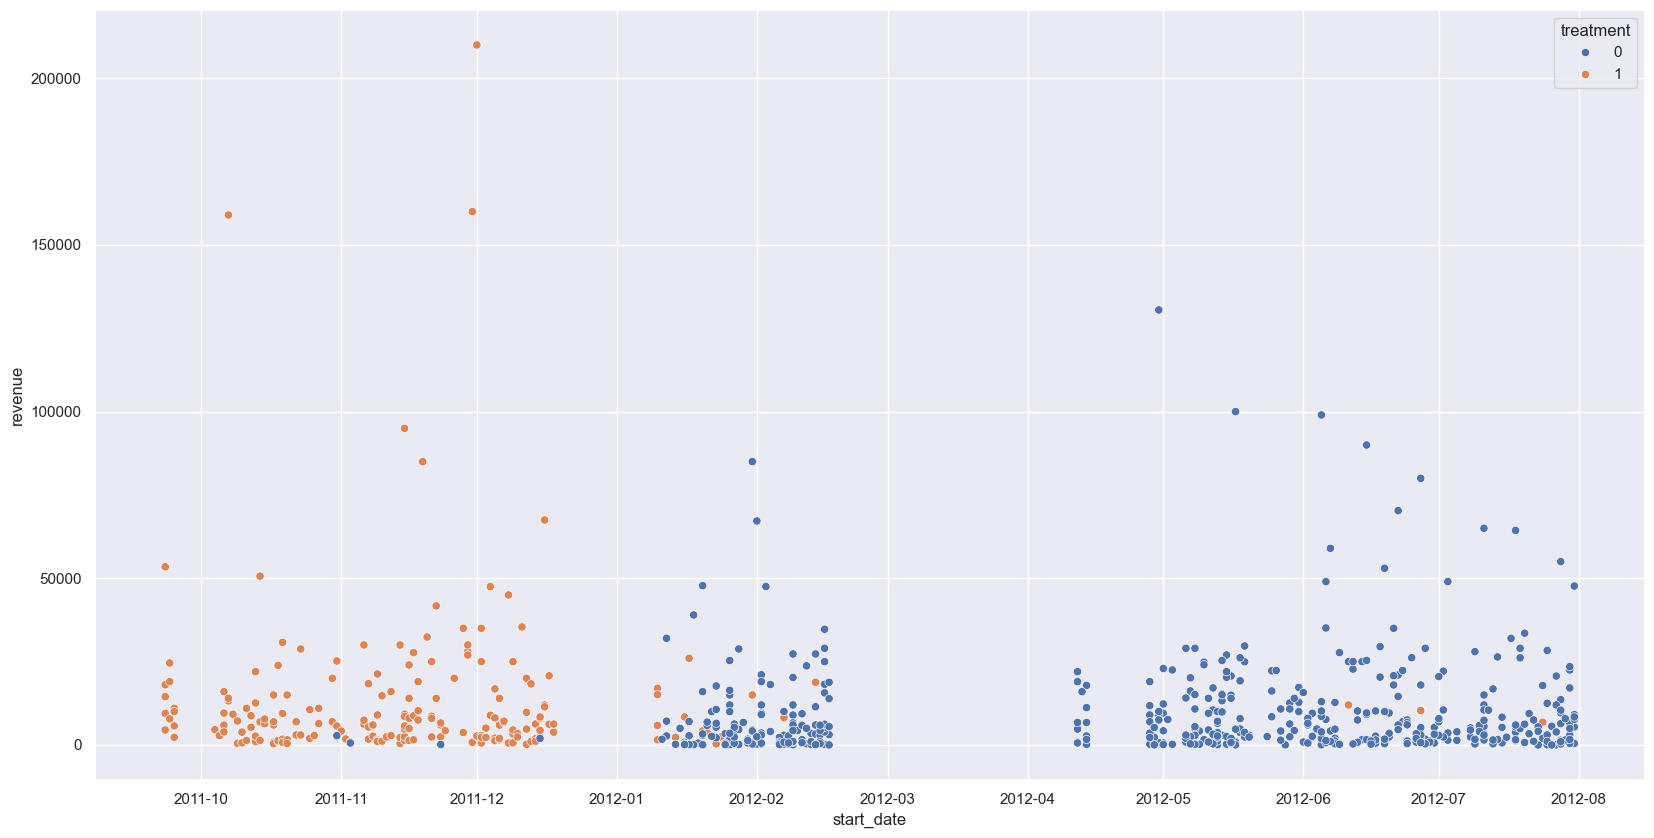

In [25]:
# stating date can also determine treatment value for most cases
# so we do not include it in the propensity score calculation
df.start_date = pd.to_datetime(df.start_date)
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=df, x='start_date', y='revenue', hue='treatment')

/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='ps2', ylabel='Count'>

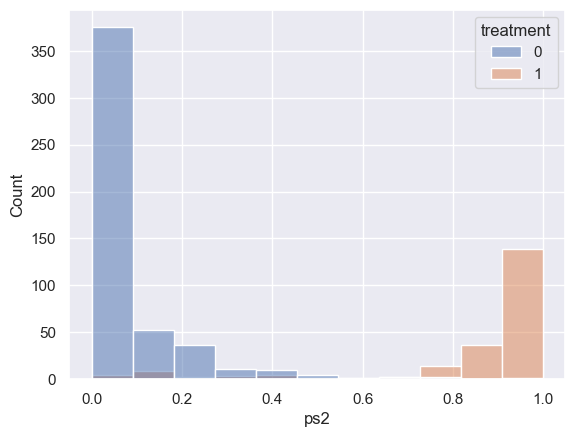

In [26]:
# adding 'starting_date' here via a `recency` feature
# there is only little overlap resulting in not enough matched observations

last_date = df.start_date.max()
df['recency'] = (last_date - df.start_date).dt.days

X2 = df[['recency', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X2, y)

pred_prob2 = lr2.predict_proba(X2)  # probabilities for classes
df['ps2'] = pred_prob2[:, 1]

sns.histplot(data=df, x='ps2', hue='treatment')

In [27]:
# use 25% of standard deviation of the propensity score as the caliper/radius
# get the k closest neighbors for each observations
# relax caliper and increase k can provide more matches

from sklearn.neighbors import NearestNeighbors

caliper = np.std(df.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = df[['ps']]  # double brackets as a dataframe
knn.fit(ps)


caliper (radius) is: 0.0304


NearestNeighbors(n_neighbors=10, radius=0.030379121102554488)